In [1]:
library(ellipse)
library(ggplot2)
library(mvtnorm)
library(gridExtra)


Attaching package: ‘ellipse’


The following object is masked from ‘package:graphics’:

    pairs




# Project 2

##### 1. Data loading and plots

In [2]:
data = read.table("BankGenuine.txt", header = FALSE, sep = "")
names(data) = c("LENGTH", "LEFT", "RIGHT", "BOTTOM", "TOP", "DIAGONAL")
data <- apply(data, 2, as.numeric)

In [3]:
head(data)

LENGTH,LEFT,RIGHT,BOTTOM,TOP,DIAGONAL
214.8,131.0,131.1,9.0,9.7,141.0
214.6,129.7,129.7,8.1,9.5,141.7
214.8,129.7,129.7,8.7,9.6,142.2
214.8,129.7,129.6,7.5,10.4,142.0
215.0,129.6,129.7,10.4,7.7,141.8
215.7,130.8,130.5,9.0,10.1,141.4


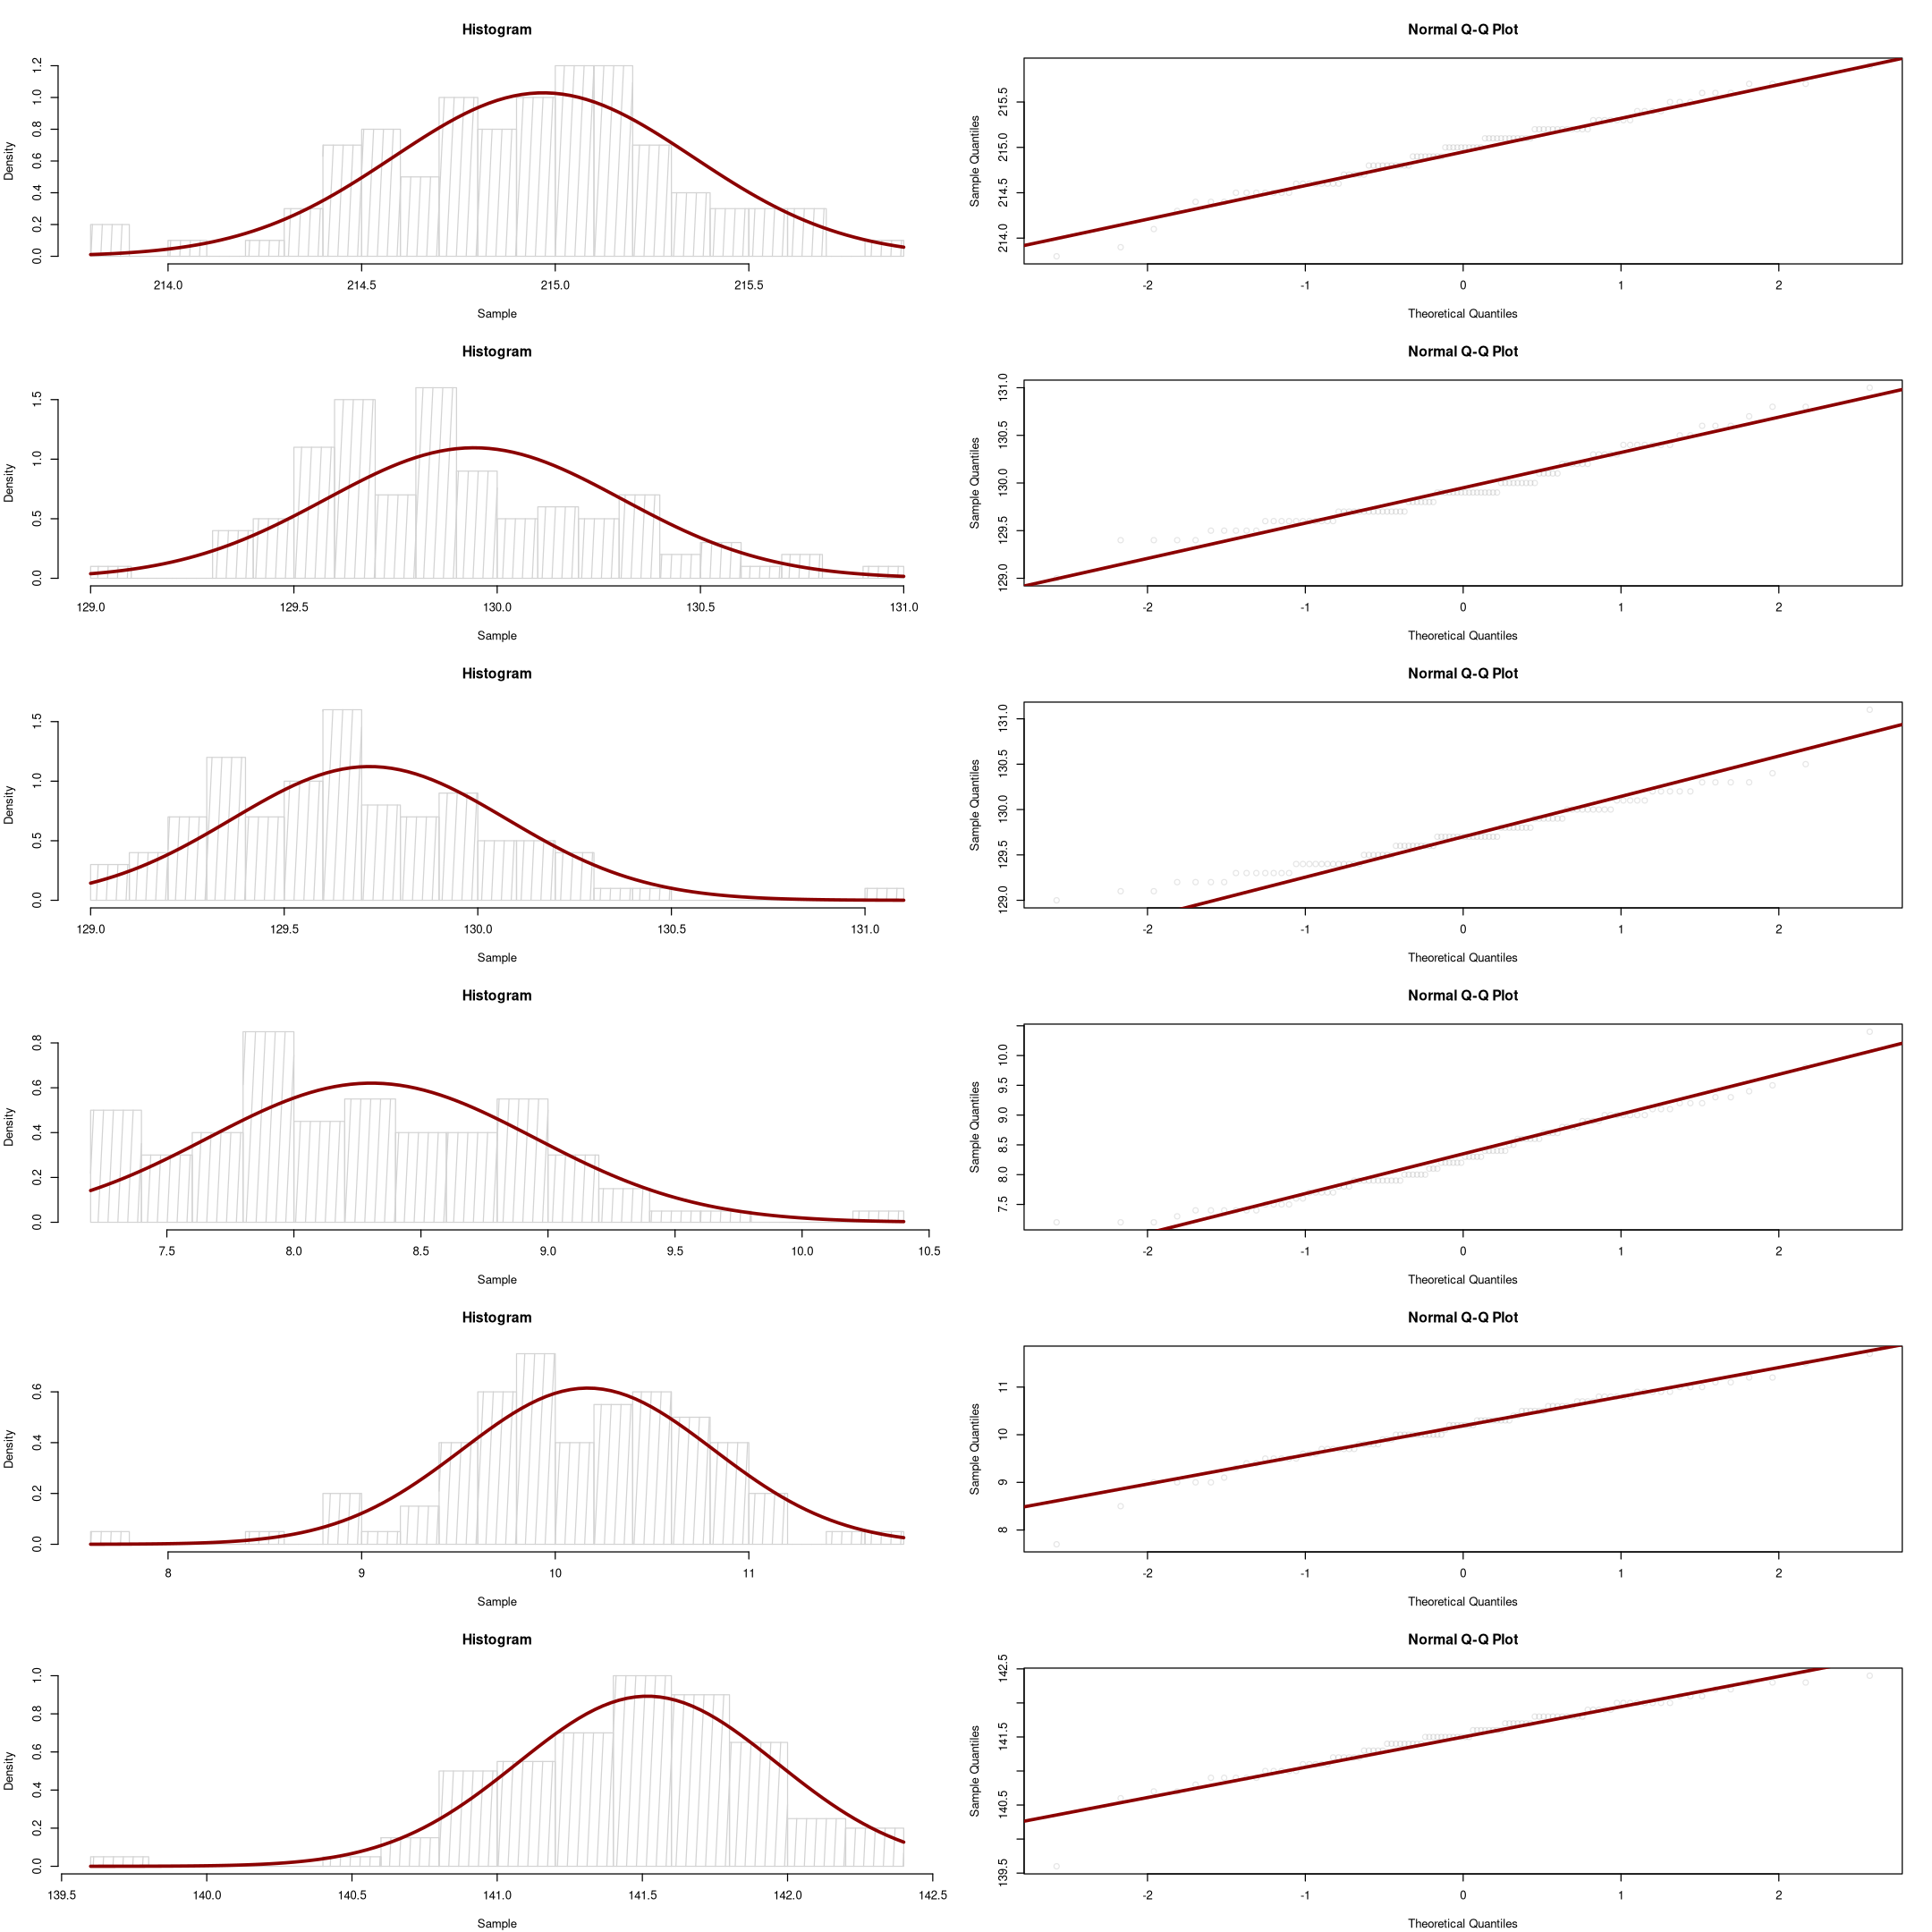

In [4]:
par(mfrow = c(6, 2), mar=c(4.1, 4.1, 4.1, 2.1))
options(repr.plot.width=18, repr.plot.height=18)

for (i in 1:6) {
	Sample = data[,i]
	hist(Sample, density=50, breaks=16, prob=TRUE, main="Histogram")
	curve(dnorm(x, mean=mean(Sample), sd=sqrt(var(Sample))), col="darkred", lwd=3, add=TRUE)

	qqnorm(Sample, col = rgb(red = 0, green = 0, blue = 0, alpha = 0.1))
	qqline(Sample, col="darkred", lwd=3)
}

##### 2. Mean and covariance estimators

In [5]:
µ = colMeans(data); µ

LENGTH     LEFT    RIGHT   BOTTOM      TOP DIAGONAL 
 214.969  129.943  129.720    8.305   10.168  141.517

In [6]:
𝞢 = cov(data); 𝞢

,LENGTH,LEFT,RIGHT,BOTTOM,TOP,DIAGONAL
LENGTH,0.150241414,0.05801313,0.05729293,0.0571262626,0.01445253,0.0054818182
LEFT,0.058013131,0.13257677,0.08589899,0.0566515152,0.04906667,-0.0430616162
RIGHT,0.057292929,0.08589899,0.12626263,0.0581818182,0.03064646,-0.0237777778
BOTTOM,0.057126263,0.05665152,0.05818182,0.4132070707,-0.26347475,-0.0001868687
TOP,0.014452525,0.04906667,0.03064646,-0.2634747475,0.42118788,-0.0753090909
DIAGONAL,0.005481818,-0.04306162,-0.02377778,-0.0001868687,-0.07530909,0.1998090909


##### 3. Confidence region based on Hotteling statistic

In [7]:
boundary.statistic = function(n, p, level) p*(n-1)/(n-p)*qf(level, p, n-p) / n
is_within_ellipse = function(v, mu, sigma, level = 0.95, n = length(data)) {
	return( t(v - mu) %*% solve(sigma) %*% (v - mu) <= boundary.statistic(n, length(mu), level) )
}

##### 4. Hotteling confidence region test

In [8]:
new.means = c(214.97, 130, 129.67, 8.3, 10.16, 141.5)
is_within_ellipse(new.means, µ, 𝞢)[1]

[1] FALSE

##### 5. Bonferroni confidence region test

In [9]:
bonferroni.confidence.region = function (data, conf.level=0.95) {
	bonferroni.conf.level = conf.level / ncol(data)
	ttest.confidence.interval = function (sample, conf.level)
		t.test(sample, conf.level=bonferroni.conf.level)$conf.int
	
	confidence.intervals = apply(data, 2, ttest.confidence.interval)
	return (confidence.intervals)
}

bonferroni.confidence.region.test = function(data, means, conf.level=0.95) {
	confidence.intervals = bonferroni.confidence.region(data, conf.level=conf.level)
	return( all(apply(t(confidence.intervals) - means, 1, prod) < 0) )
}

In [10]:
bonferroni.confidence.region.test(data, new.means)[1]

[1] FALSE

##### plotz

In [11]:
regions = bonferroni.confidence.region(data)

In [12]:
# https://rdrr.io/cran/ellipse/man/ellipse.html
confidence.ellipse = function(mu, sigma, which=c(1, 2), level=0.95, rescale = TRUE, n = nrow(data)) {
	plotz = ggplot() + geom_path() + theme_bw()
	
	if (!rescale)
		plotz = plotz + coord_equal()
		
	ellipse_data1 = ellipse(x = sigma, centre = mu[which], which = which, t = boundary.statistic(n, 2, level))
	colnames(ellipse_data1) = c("x", "y")
	plotz = plotz + geom_path(data = ellipse_data1, aes(x, y), color = "black", alpha=sqrt(1-level))

	return(plotz)
}

In [13]:
line.projection = function(µ, 𝞢, m, d=data, which=1) {
	rect.region = t.test(data[,which], conf.level=0.95)$conf.int
	# Plot the line segment representing the interval
	a = rect.region[1]
	b = rect.region[2]
	plot(c(a, b), c(0, 0), type = "l", xlab = "", ylab = "", main = colnames(data)[which])

	# Mark the interval with brackets
	segments(a, 0, b, 0, lwd = 2, col = "black")

	# Mark the point on the line
	points(m[which], 0, pch = 17, col = "darkred", cex=6)
	# axis(1, at = data[,which], las=3)
}

plot.line.projections = function(µ, 𝞢, m, d=data) {
	par(mfrow = c(2, 3), mar=c(4.1, 4.1, 4.1, 4.1), yaxt = "n", pty = "s", bty = "n")
	options(repr.plot.width=18, repr.plot.height=10)
	for (i in 1:6)
		line.projection(µ, 𝞢, m, d=d, which=i)
}

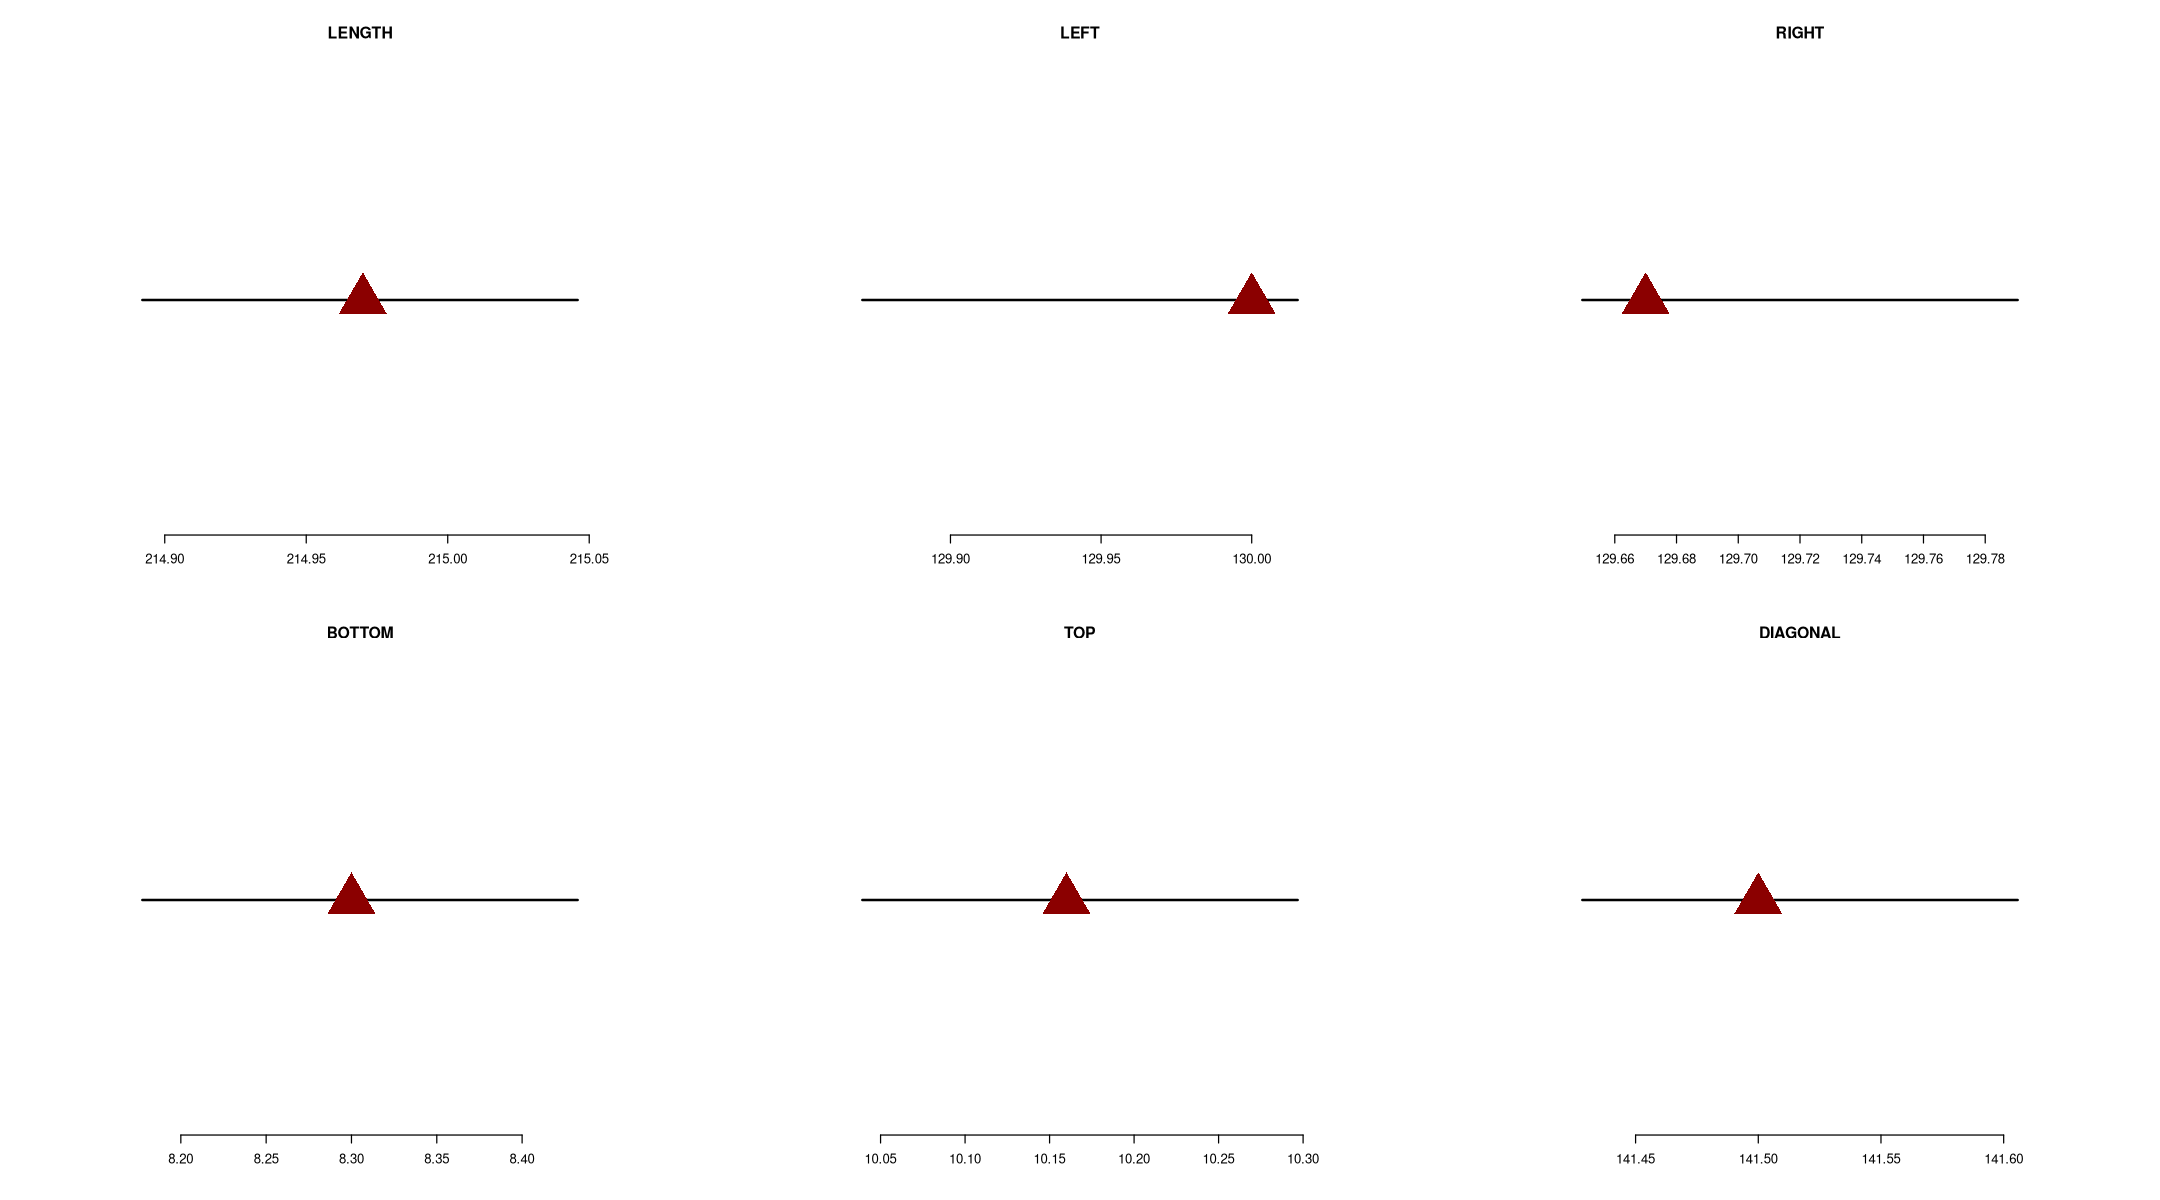

In [14]:
plot.line.projections(µ, 𝞢, new.means)

In [15]:
plane.projection = function(µ, 𝞢, m, d=data, which=c(2, 3)) {
	m = data.frame(t(m[which]))
	colnames(m) = c("x", "y")

	rect.region = bonferroni.confidence.region(d[,which])

	confidence.ellipse(µ, 𝞢, which=which) +
	theme(axis.title.x=element_blank(), axis.title.y=element_blank()) +
	geom_point(d = m, aes(x, y), size=3, alpha=0.8, pch=17, color="darkred") +
	geom_rect(aes(
		xmin=rect.region[1,1],
		xmax=rect.region[2,1],
		ymin=rect.region[1,2],
		ymax=rect.region[2,2]
	), alpha=0, color="grey")
}

In [16]:
text.plot = function(txt) {
	ggplot() + 
	annotate("text", x = 4, y = 25, size=8, label = txt) + 
	theme_void()
}

In [17]:
plot.plane.projections = function(point) {
	options(repr.plot.width=18, repr.plot.height=18)
	plots = vector('list', 36)
	for (i in 1:6) for (j in 1:6) {
		if (i == j) {
			plot = text.plot(colnames(data)[i])
		} else {
			plot = plane.projection(µ, 𝞢, m=point, which=c(j, i))
		}
		plots[[6*(i-1) + j]] = plot
	}
	do.call(grid.arrange, plots)
}

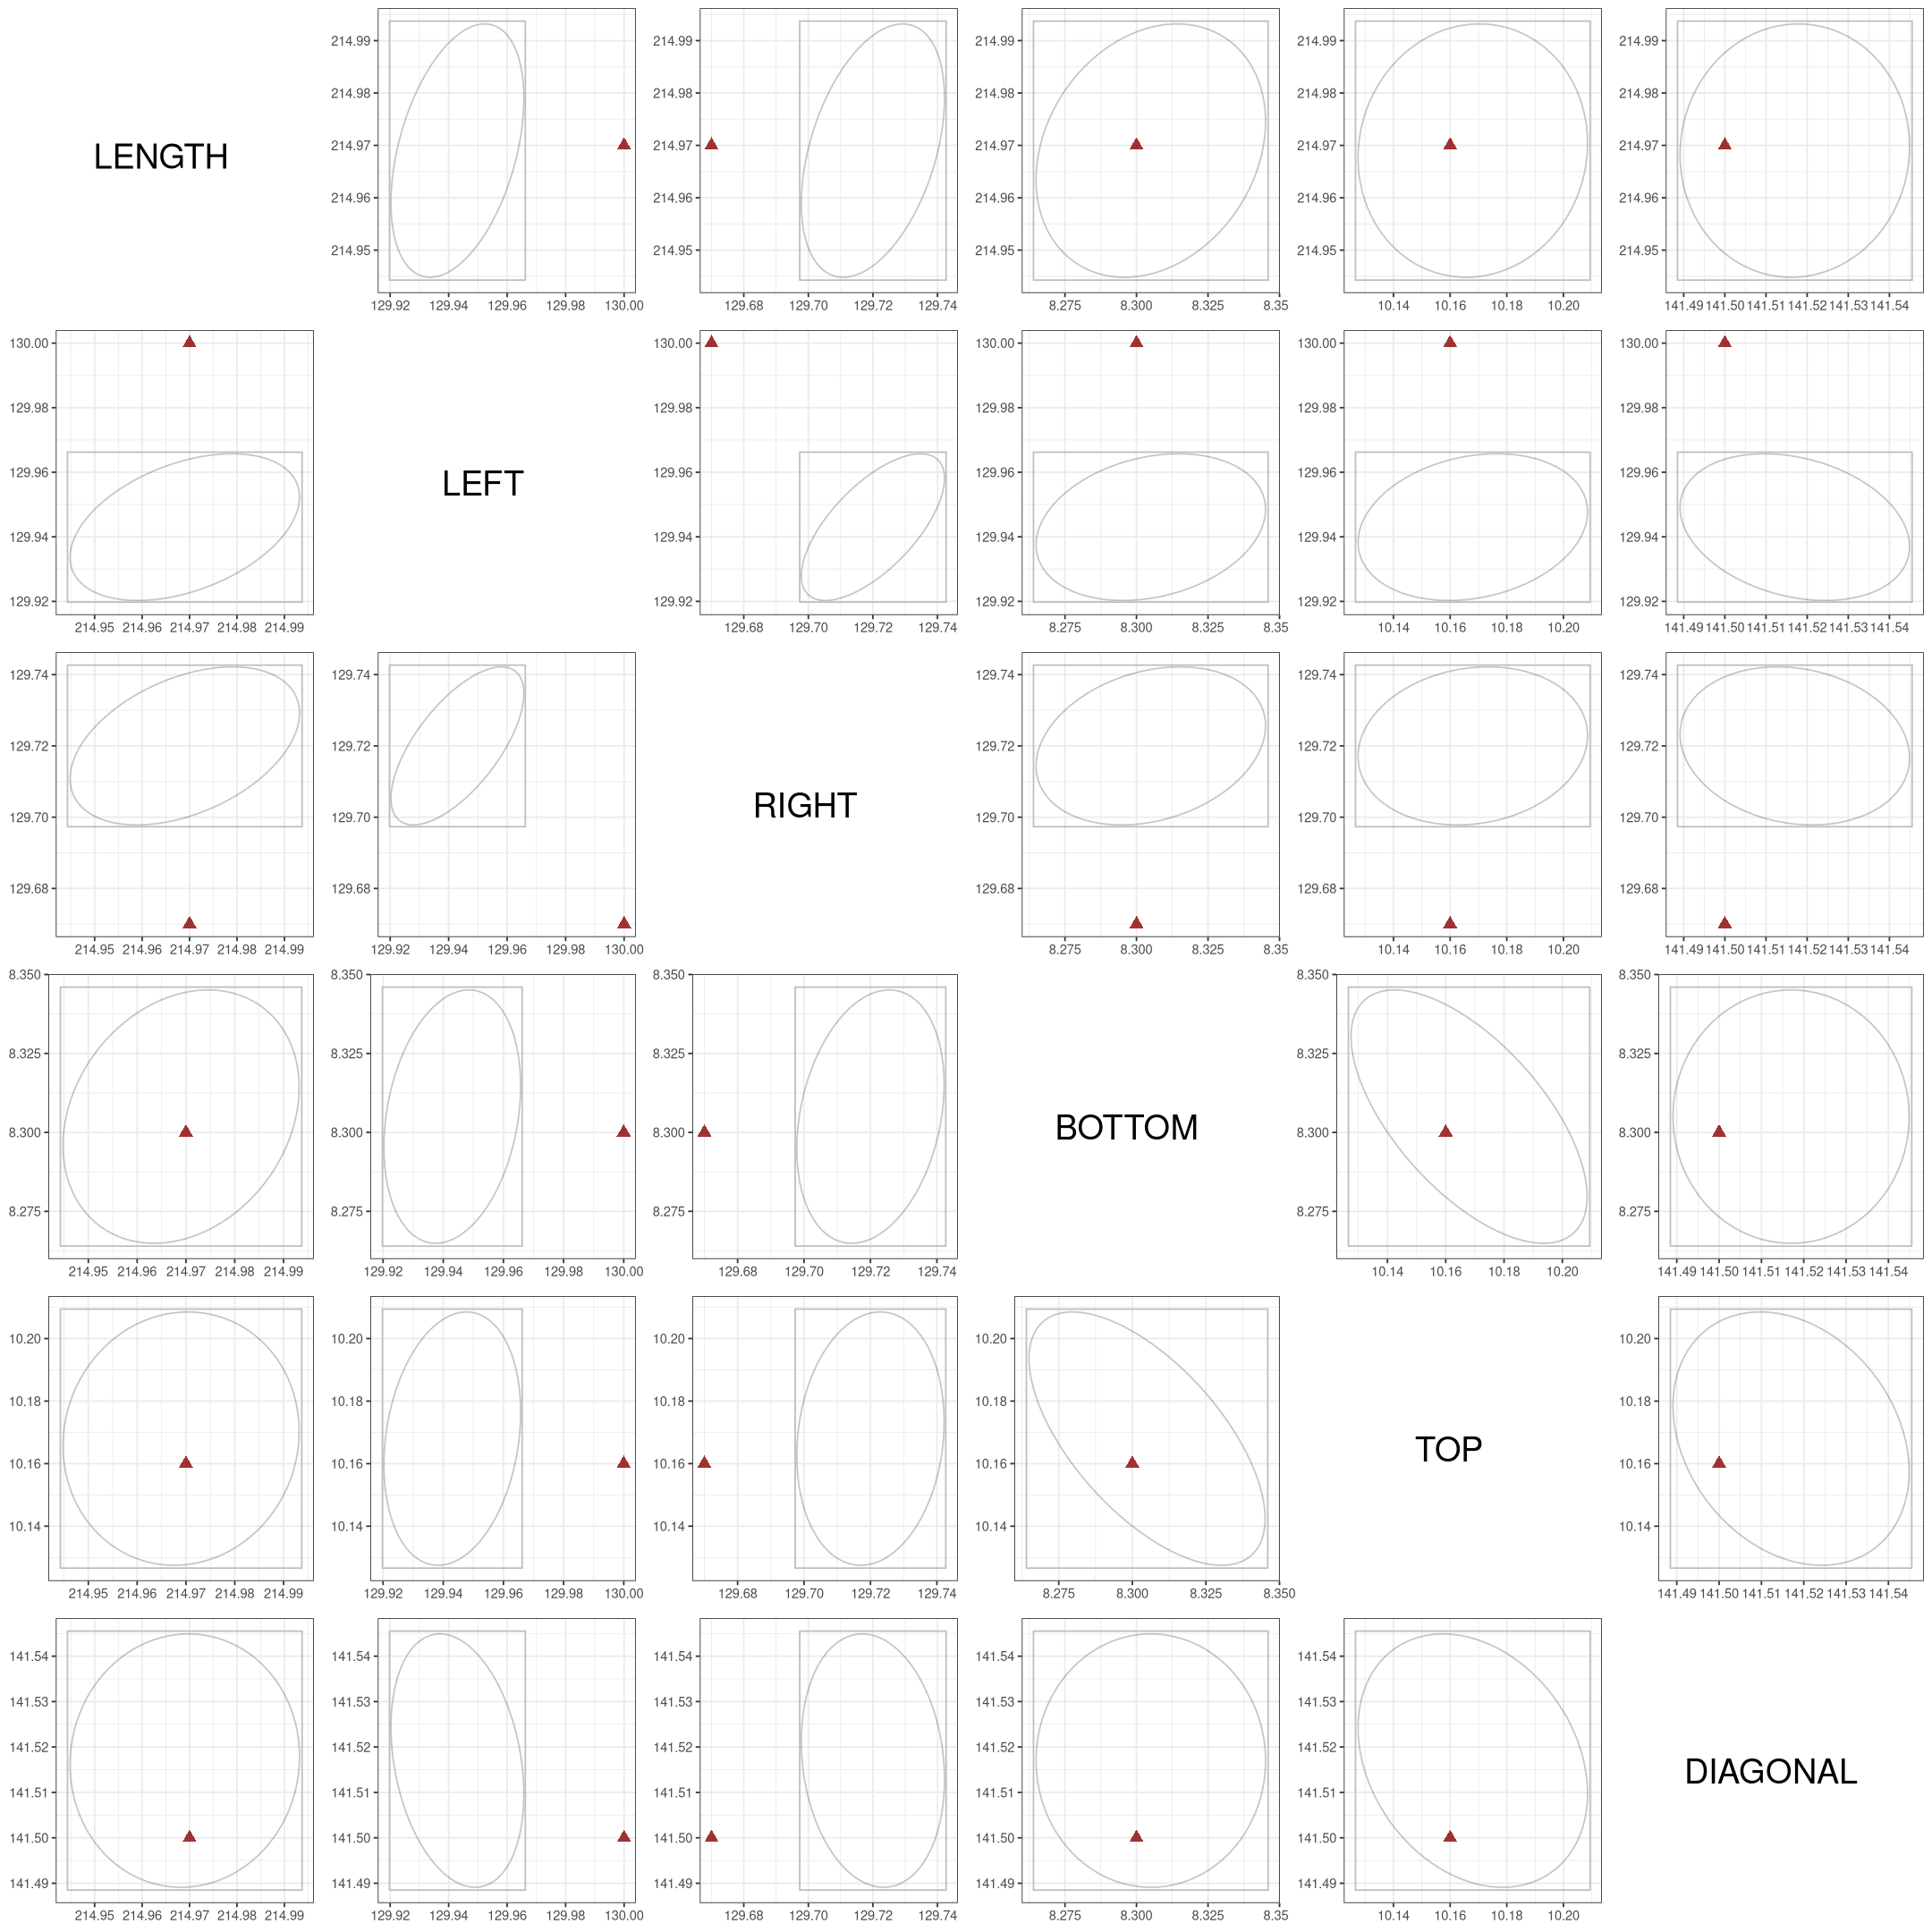

In [18]:
plot.plane.projections(new.means)

##### Test another means vector

In [19]:
new.means2 = c(214.99, 129.95, 129.73, 8.51, 9.96, 141.55)

In [20]:
is_within_ellipse(new.means2, µ, 𝞢)[1]

[1] FALSE

In [21]:
bonferroni.confidence.region.test(data, new.means2)[1]

[1] FALSE

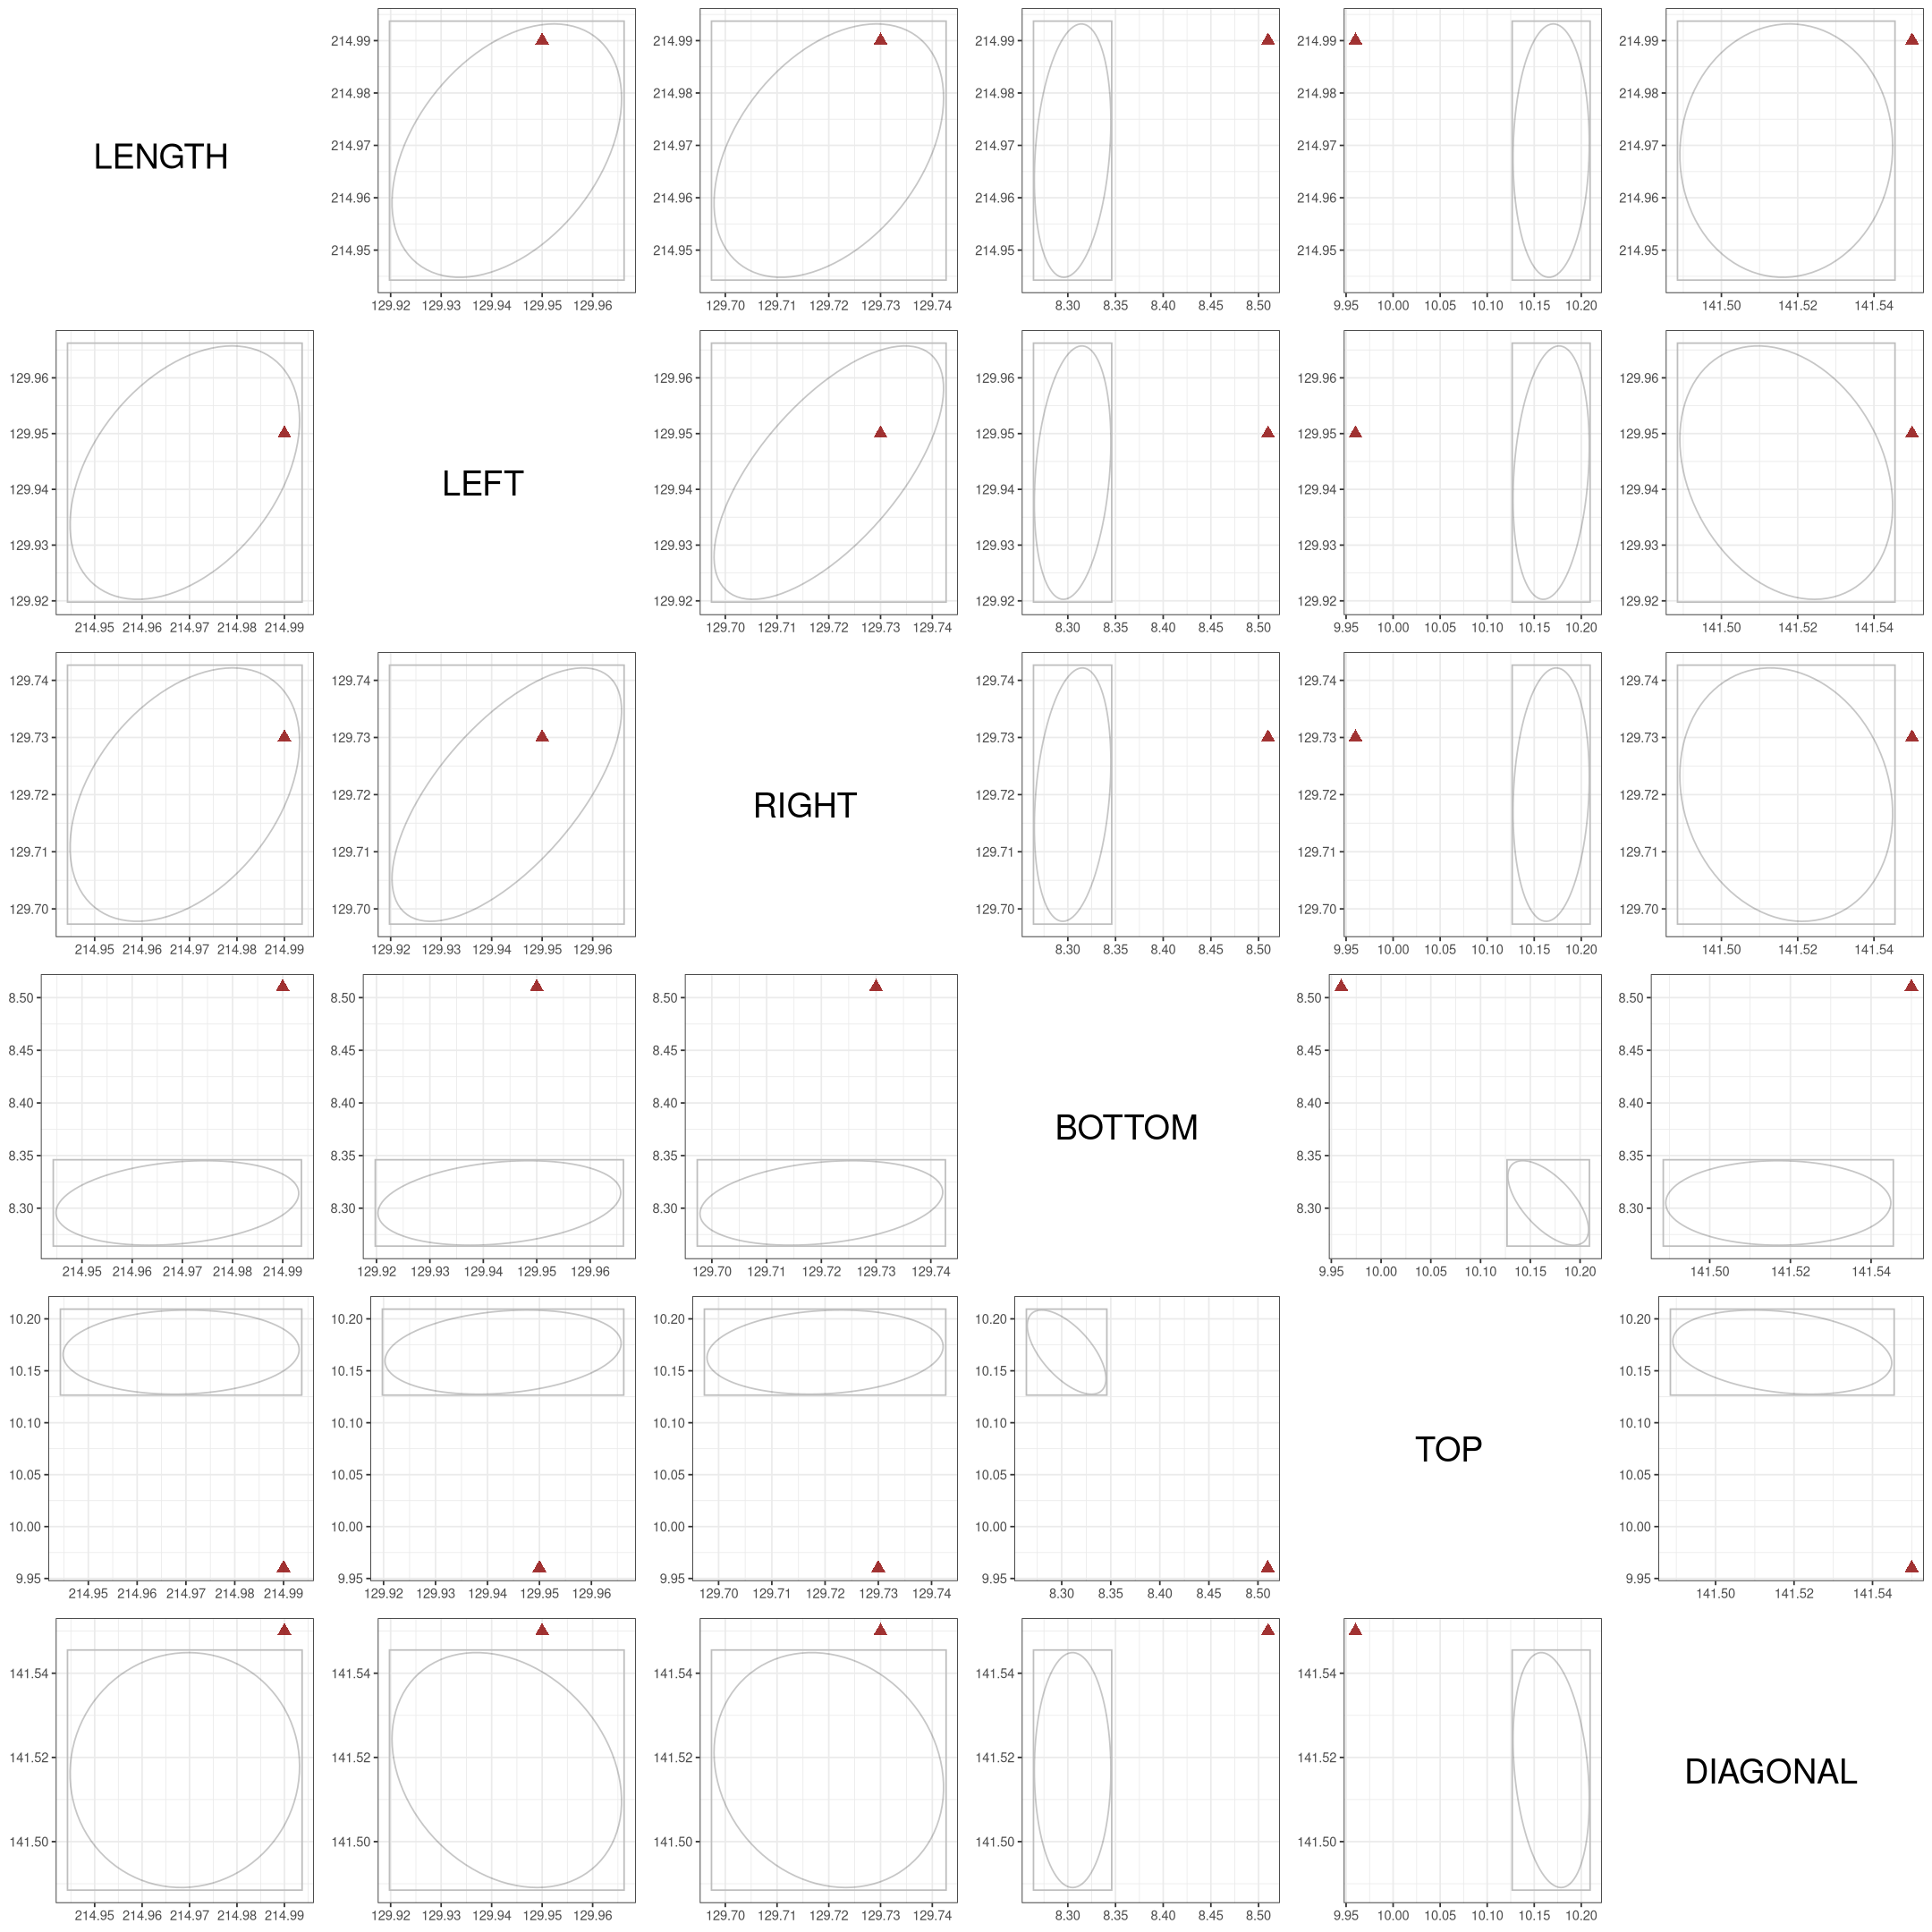

In [22]:
plot.plane.projections(new.means2)

##### Test yet another means vector

In [23]:
new.means3 = c(214.9473, 129.9243, 129.6709, 8.3254, 10.0389, 141.4954)

In [24]:
is_within_ellipse(new.means3, µ, 𝞢)[1]

[1] FALSE

In [25]:
bonferroni.confidence.region.test(data, new.means3)[1]

[1] FALSE

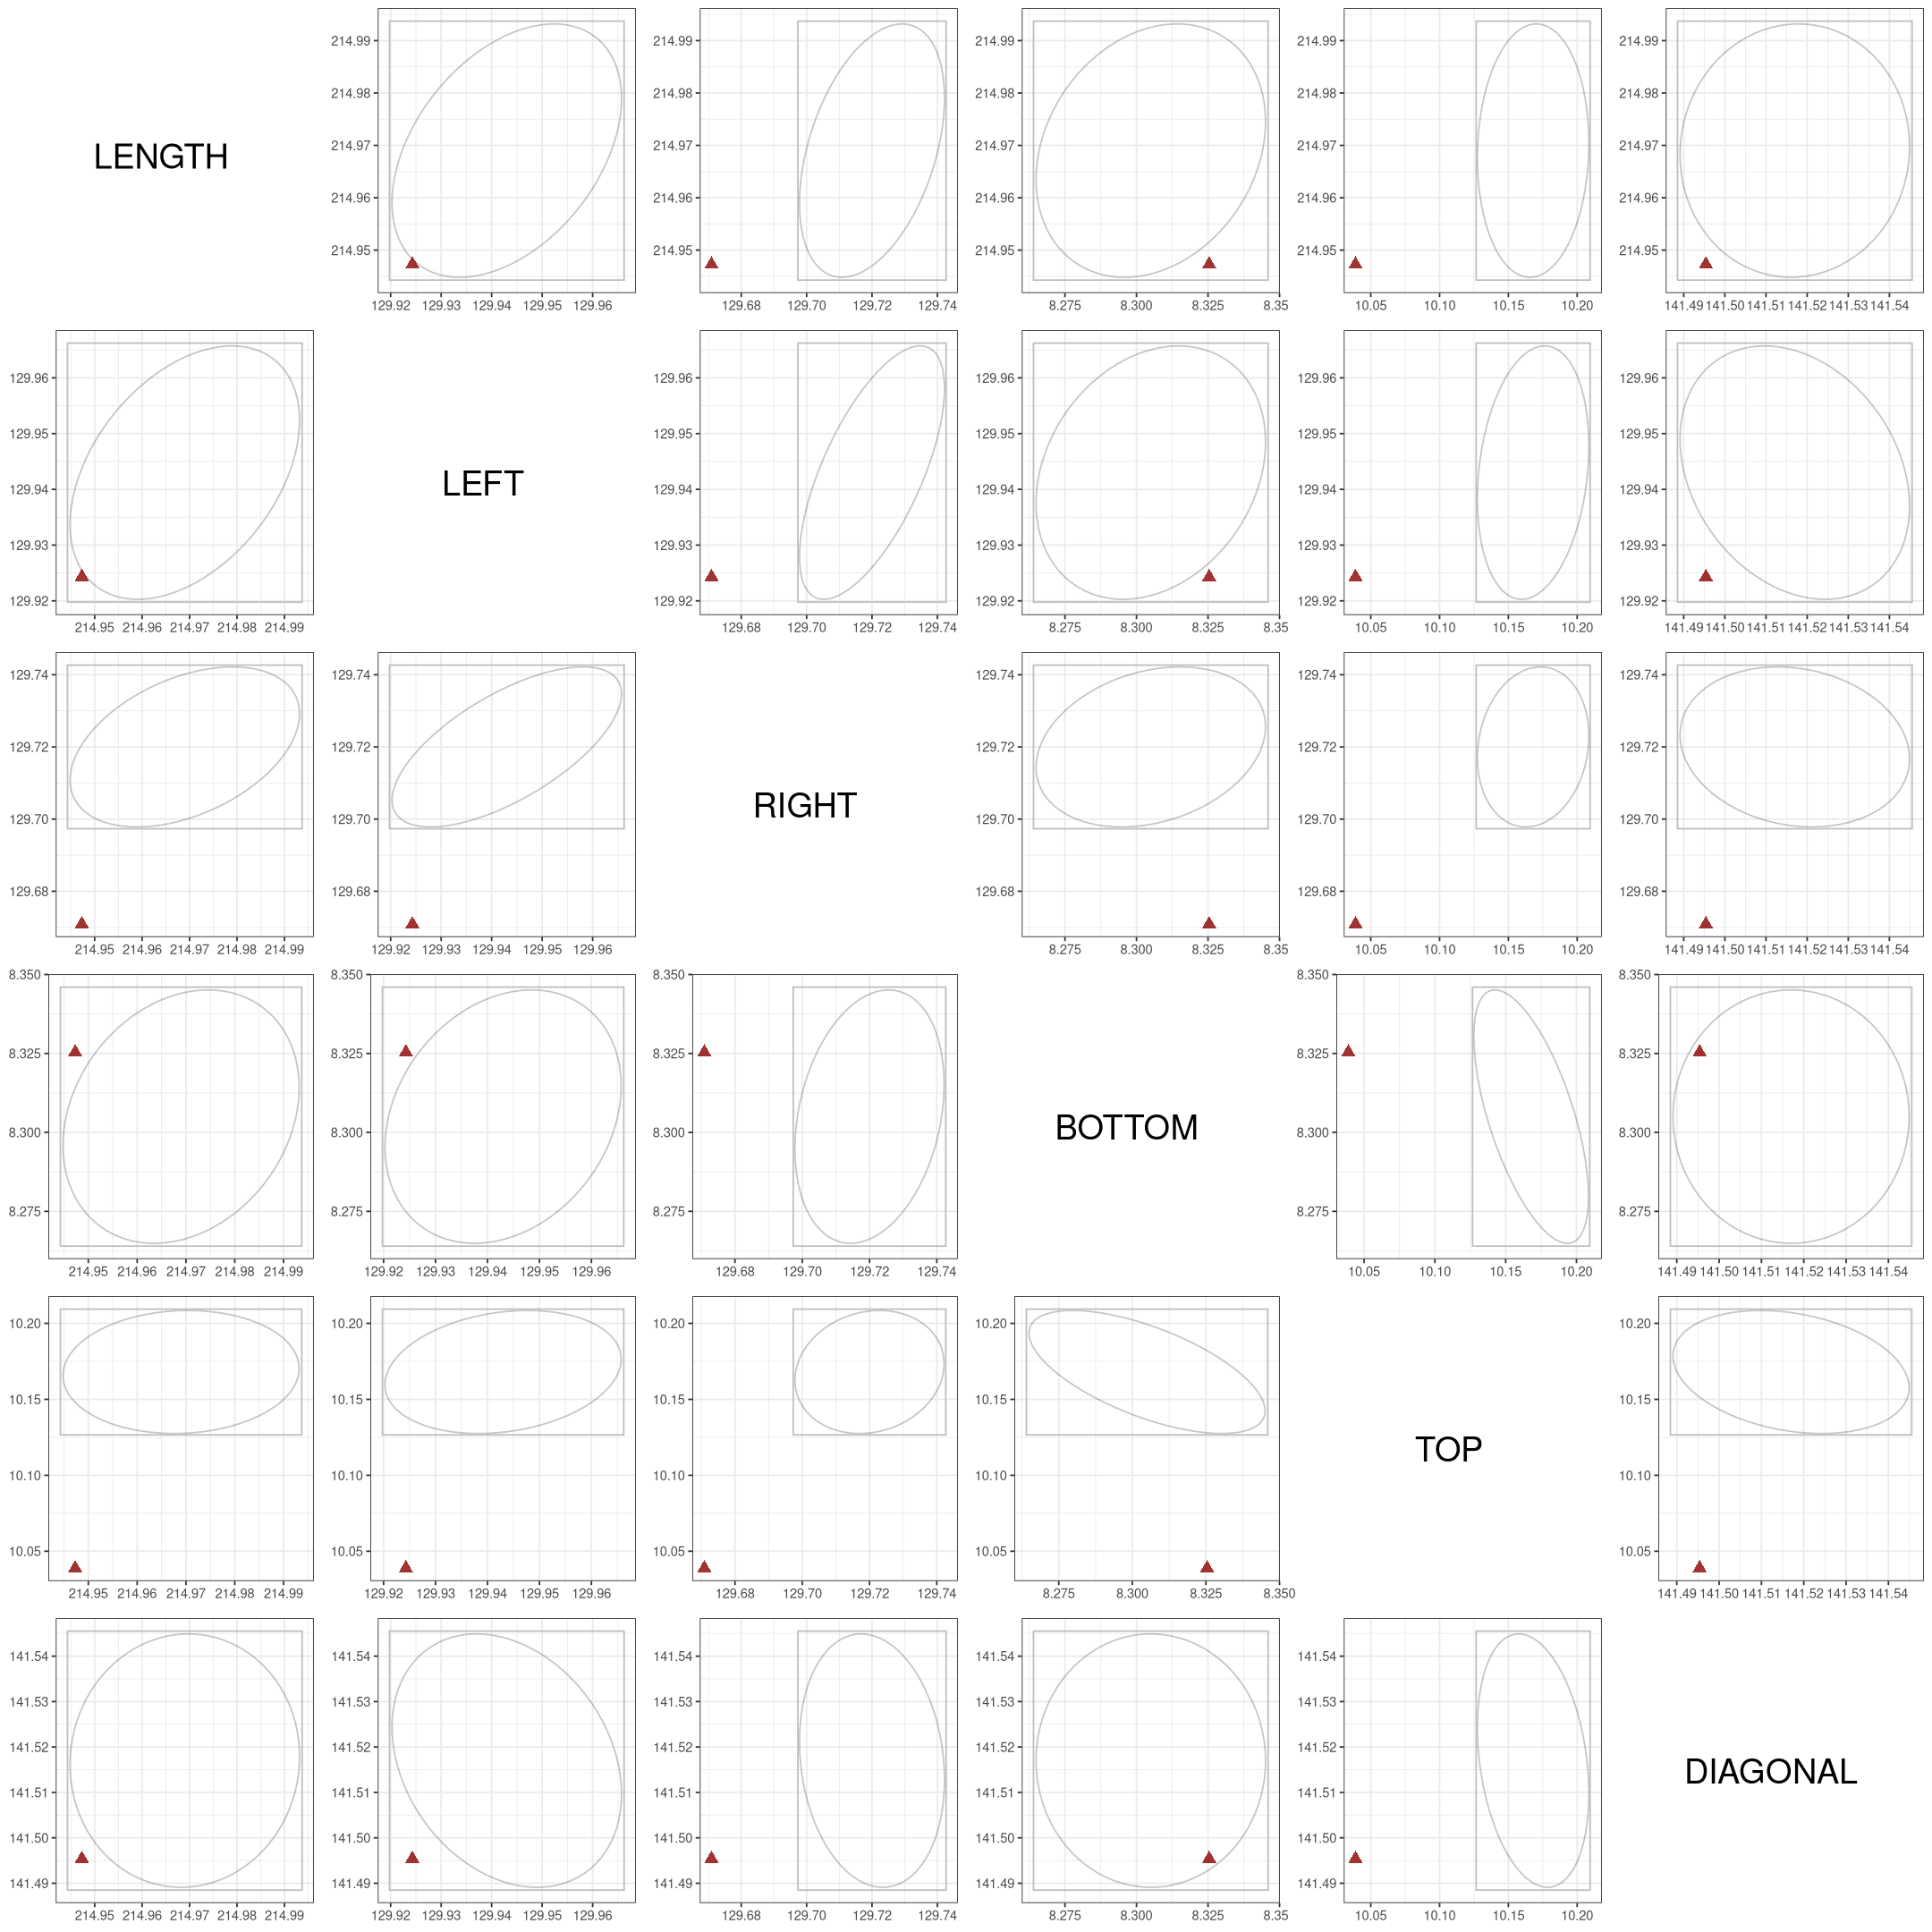

In [26]:
plot.plane.projections(new.means3)

# Simulation 1

In [30]:
multitest = function(p, µ, alpha, method = "bonferroni") {
	false.head = sum(µ != 0)
	# p.values = pnorm(rnorm(p, mean=µ, sd=1))
	# reject.left = p.adjust(p.values, method = method) < alpha
	# reject.rght = 1-p.adjust(p.values, method = method) < alpha
	
	p.values = 2 - 2 * pnorm(abs(rnorm(p, mean=µ, sd=1)))
	# reject.left = p*p.values*2 < alpha
	# reject.rght = 1-p*p.values*2 < alpha

	# q.values = qnorm(p.adjust(p.values, method = method))
	# rejections = abs(q.values) >= qnorm(1-alpha/2/p)
	rejections = p.adjust(p.values, method = method) < alpha
	
	# X = rnorm(p, mean=µ, sd=1)
	# reject.left = X < qnorm(alpha/2/p)
	# reject.rght = X > qnorm(1 - alpha/2/p)
	# rejections = reject.left | reject.rght
	# X = abs(rnorm(p, mean=µ, sd=1))
	# rejections = X >= qnorm(1 - alpha/2/p)

	return(c(
		rejected = any(rejections),
		fdr = sum(rejections[(false.head+1):length(rejections)]) / max(1, sum(rejections)),
		power = sum(rejections[1:(false.head+1)]) / false.head
	))
}

simulate.multiple.testing = function(µ, alpha=0.05, reps=1000){
	p = length(µ)
	bf = replicate(reps, multitest(p, µ, alpha, method="bonferroni"))
	bh = replicate(reps, multitest(p, µ, alpha, method="BH"))
	return(data.frame(
		bf = rowMeans(bf),
		bh = rowMeans(bh)
	))
}

In [31]:
p = 5000
µa = c(rep(sqrt(2 * log(p)), 10), rep(0, p - 10))
simulate.multiple.testing(µa, reps=10000)

,bf,bh
,<dbl>,<dbl>
rejected,0.99270000,0.9934000
fdr,0.01129766,0.0486361
power,0.38211000,0.5422100


In [32]:
µb = c(rep(sqrt(2 * log(p)), 500), rep(0, p - 500))
simulate.multiple.testing(µb, reps=10000)

,bf,bh
,<dbl>,<dbl>
rejected,1.0000000000,1.00000000
fdr,0.0002427796,0.04483642
power,0.3858656000,0.90364220
